In [78]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Laoding dataset to perform EDA

In [79]:
df_geo_info = pd.read_parquet("../Datasets/filtered_dataset_with_geo_info.parquet.gzip")

In [80]:
df_geo_info.head()

,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,state,yearOfLoss,elevatedBuildingIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,occupancyType,rateMethod,crsClassificationCode,elevationCertificateIndicator,lowestFloorElevation,lowestAdjacentGrade,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,primaryResidenceIndicator,buildingPropertyValue,causeOfDamage,contentsPropertyValue,disasterAssistanceCoverageRequired,floodCharacteristicsIndicator,floodproofedIndicator,buildingReplacementCost,contentsReplacementCost,waterDepth,floodZoneCurrent,rentalPropertyIndicator,postFIRMConstructionIndicator,buildingrelativeDamage,AgeofBuildinguntilflood,AgeofPolicyuntilflood,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30
0,32940,12009,12009063107,120090631073,28.3,-80.7,FL,1996,0,NaN,NaN,X,1.0,7,8.0,None,NaN,NaN,100000.0,25000.0,1,100000.0,1,0.0,0.0,NaN,0,0.0,0.0,0.0,None,0,1,0.052520,8.0,8.0,-0.191515,-0.277861,0.438251,-0.135808,0.257442,-0.905254,0.517394,0.198713,-1.311131,-0.560012,0.519368,0.064180,0.600630,1.447684,0.548300,1.195442,-1.206848,-1.677352,-0.290665,-0.008914,0.911473,-0.777211,-0.634360,0.905508,2.180291,-0.533245,0.392365,2.021945,-0.417581,-0.243402
1,23505,51710,51710001200,517100012001,36.9,-76.3,VA,2009,0,NaN,NaN,X,1.0,1,9.0,None,NaN,NaN,150000.0,0.0,0,37260.0,1,NaN,0.0,NaN,0,113263.0,NaN,1.0,A04,0,0,0.083494,57.0,57.0,-0.440167,-0.026508,-0.265916,-0.101934,-0.578929,-0.273033,-0.381519,-0.066282,-0.761965,-0.364831,-0.789079,2.972900,-1.743709,4.187647,-1.028620,0.660021,0.302219,0.764221,-1.073185,-2.093600,0.419692,3.275569,-1.975996,-1.032234,22.982420,-3.494600,-1.374440,2.460046,9.894575,-4.918725
2,32583,12113,12113010809,121130108091,30.6,-87.0,FL,2004,0,NaN,NaN,C,1.0,1,7.0,None,NaN,NaN,239300.0,45300.0,1,191440.0,1,0.0,0.0,NaN,0,239300.0,0.0,0.0,AE,0,0,0.011737,38.0,38.0,-0.487011,-0.178706,0.300662,-0.180206,-0.122099,-0.252817,0.428306,0.024471,-0.140899,-0.029402,-0.572798,-0.472122,0.110230,-0.315755,-0.226288,-0.048457,-0.005177,-0.584027,1.562803,-0.141775,0.261002,-0.439834,-0.024958,0.928115,-0.028791,-0.085646,0.008390,0.015467,0.285856,-0.134586
3,32507,12033,12033002300,120330023004,30.4,-87.3,FL,2004,0,4.0,7.0,AE,1.0,1,8.0,None,11.0,NaN,102500.0,44800.0,1,82000.0,1,0.0,0.0,NaN,0,102500.0,0.0,0.0,None,0,0,0.800366,56.0,56.0,-0.389182,-0.143250,0.341384,-0.081046,0.291763,-0.666212,1.571670,-0.164597,0.058252,0.231910,0.912889,-0.768089,0.094755,0.005752,0.353880,-1.412354,1.136864,0.353490,1.320365,-0.010683,-0.476934,-0.085460,0.244494,-0.964397,0.431071,-0.234543,-0.055565,-0.255935,0.248011,-0.083549
4,28445,37141,37141920101,371419201011,34.4,-77.6,NC,1996,0,3.0,11.0,AE,1.0,1,9.0,None,13.6,NaN,73700.0,4300.0,0,73700.0,1,NaN,0.0,NaN,0,0.0,NaN,0.0,None,0,1,0.070583,17.0,17.0,-0.572386,-0.142794,0.306223,0.106274,0.035533,-0.221587,0.990321,-0.207453,0.470000,0.379363,1.012849,0.526264,0.347955,-0.959901,0.987863,0.029553,0.721367,0.199539,-0.391917,0.175819,-2.181929,0.966825,-0.223965,-0.775800,-0.592636,0.068290,-0.039304,0.535170,0.338631,-0.260381


In [81]:
print(f'size of the dataset before dropping: {df_geo_info.shape[0]}')

size of the dataset before dropping: 209742


## Missing Value Analysis for geo_info svd columns only

In [82]:
print(f'Absolute numbers:\n{df_geo_info.isna().sum()}')
print(f'percentage of the total data:\n{df_geo_info.isna().sum()*100/df_geo_info.shape[0]}')

Absolute numbers:
reportedZipCode                            0
countyCode                                 0
censusTract                                0
censusBlockGroupFips                       0
latitude                                   0
longitude                                  0
state                                      0
yearOfLoss                                 0
elevatedBuildingIndicator                  0
elevationDifference                   134807
baseFloodElevation                    135141
ratedFloodZone                            26
occupancyType                              0
rateMethod                                15
crsClassificationCode                  70170
elevationCertificateIndicator         172287
lowestFloorElevation                  134704
lowestAdjacentGrade                   140635
totalBuildingInsuranceCoverage            15
totalContentsInsuranceCoverage            16
primaryResidenceIndicator                  0
buildingPropertyValue                

In [83]:
# Since we are trying to evaluate geo_info columns, hence dropping the rows with NaN values 3.1% of the dataset  
# (all these are coastal locations, will resolve it by insteresting the geographic unit with continental US shapefile)

svd_columns = [f'svd_{i}' for i in range(1, 31)]

df_geo_info.dropna(subset=svd_columns, inplace=True)

In [84]:
print(f'size of the dataseta after dropping na values: {df_geo_info.shape[0]}')

size of the dataseta after dropping na values: 203227


## Target Variable Analysis

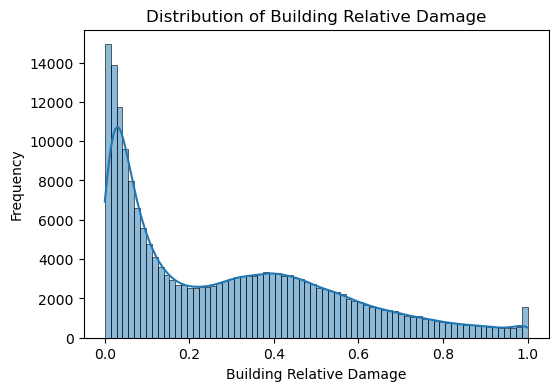

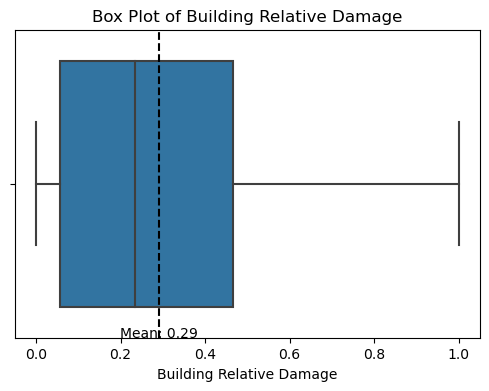

In [85]:
plt.figure(figsize=(6, 4))
sns.histplot(df_geo_info['buildingrelativeDamage'], kde=True)  # KDE=True adds a density plot
plt.title('Distribution of Building Relative Damage')
plt.xlabel('Building Relative Damage')
plt.ylabel('Frequency')
plt.show()

# Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_geo_info['buildingrelativeDamage'])
plt.title('Box Plot of Building Relative Damage')
plt.xlabel('Building Relative Damage')

# Calculate the mean and plot it
mean_value = df_geo_info['buildingrelativeDamage'].mean()
plt.axvline(mean_value, color='black', linestyle='--')
plt.text(mean_value, 0.5, f'Mean: {mean_value:.2f}', color = 'black', ha='center')

plt.show()

The distribution of the target variable is like a mixture model with median around 0.22

## Missing Value Analysis of FEMA columns 

In [86]:
df_geo_info.dtypes

reportedZipCode                        object
countyCode                             object
censusTract                            object
censusBlockGroupFips                   object
latitude                              float64
longitude                             float64
state                                  object
yearOfLoss                              int64
elevatedBuildingIndicator               int64
elevationDifference                   float64
baseFloodElevation                    float64
ratedFloodZone                         object
occupancyType                         float64
rateMethod                             object
crsClassificationCode                 float64
elevationCertificateIndicator          object
lowestFloorElevation                  float64
lowestAdjacentGrade                   float64
totalBuildingInsuranceCoverage        float64
totalContentsInsuranceCoverage        float64
primaryResidenceIndicator               int64
buildingPropertyValue             

In [87]:
print(f'\nAbsolute numbers:\n\n{df_geo_info.isna().sum()}')
print(f'\npercentage of the total data:\n\n{df_geo_info.isna().sum()*100/df_geo_info.shape[0]}')


Absolute numbers:

reportedZipCode                            0
countyCode                                 0
censusTract                                0
censusBlockGroupFips                       0
latitude                                   0
longitude                                  0
state                                      0
yearOfLoss                                 0
elevatedBuildingIndicator                  0
elevationDifference                   131577
baseFloodElevation                    131907
ratedFloodZone                            26
occupancyType                              0
rateMethod                                15
crsClassificationCode                  68726
elevationCertificateIndicator         166728
lowestFloorElevation                  131477
lowestAdjacentGrade                   137100
totalBuildingInsuranceCoverage            15
totalContentsInsuranceCoverage            16
primaryResidenceIndicator                  0
buildingPropertyValue              

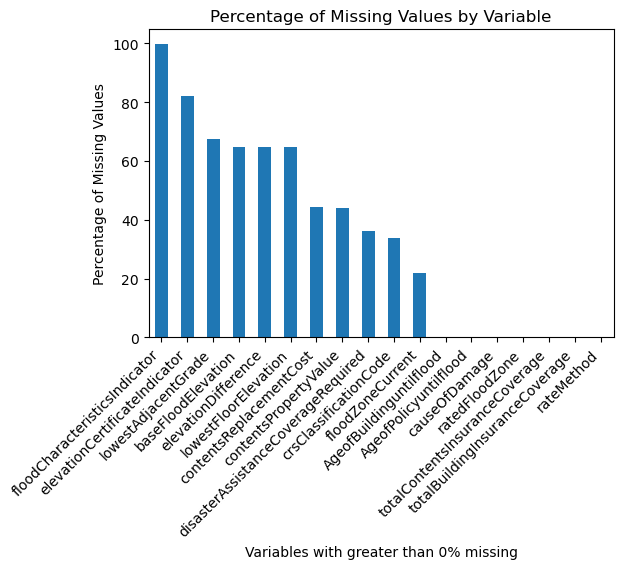

floodCharacteristicsIndicator         99.771684
elevationCertificateIndicator         82.040280
lowestAdjacentGrade                   67.461509
baseFloodElevation                    64.906238
elevationDifference                   64.743858
lowestFloorElevation                  64.694652
contentsReplacementCost               44.241661
contentsPropertyValue                 44.094535
disasterAssistanceCoverageRequired    36.223041
crsClassificationCode                 33.817357
floodZoneCurrent                      21.770729
AgeofBuildinguntilflood                0.039365
AgeofPolicyuntilflood                  0.039365
causeOfDamage                          0.031492
ratedFloodZone                         0.012794
totalContentsInsuranceCoverage         0.007873
totalBuildingInsuranceCoverage         0.007381
rateMethod                             0.007381
dtype: float64


In [88]:
missing_percent = df_geo_info.isnull().mean() * 100

missing_percent = missing_percent[missing_percent > 0]

missing_percent.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(6, 4))
missing_percent.plot.bar()
plt.title('Percentage of Missing Values by Variable')
plt.xlabel('Variables with greater than 0% missing')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha="right")
plt.show()

print(missing_percent)

99.77 % of floodCharacteristicsIndicator, 82.04% of elevationCertificateIndicator is missing. The percentage of missingness is too high to be imputed. We can drop these two. For the rest, more exploration is required to figure if any value can be imputed or not

In [89]:
columns_to_drop = ['floodCharacteristicsIndicator', 'elevationCertificateIndicator']
df_geo_info.drop(columns=columns_to_drop, inplace=True)

## Correlation Matrix of the above variables

In [92]:
numerical_cols = ['lowestAdjacentGrade', 'baseFloodElevation', 'elevationDifference', 
                  'lowestFloorElevation', 'contentsReplacementCost', 'contentsPropertyValue',
                  'disasterAssistanceCoverageRequired', 'crsClassificationCode', 'floodZoneCurrent',
                  'AgeofBuildinguntilflood', 'AgeofPolicyuntilflood', 'causeOfDamage', 
                  'ratedFloodZone', 'totalContentsInsuranceCoverage', 'totalBuildingInsuranceCoverage',
                  'rateMethod']


spearman_corr = df_geo_info[numerical_cols + ['buildingrelativeDamage']].corr(method='spearman')
spearman_corr_with_target = spearman_corr['buildingrelativeDamage'].sort_values(ascending=False)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13588\4107431063.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman_corr = df_geo_info[numerical_cols + ['buildingrelativeDamage']].corr(method='spearman')


In [93]:
spearman_corr_with_target

buildingrelativeDamage                1.000000
contentsPropertyValue                 0.181754
lowestAdjacentGrade                   0.111141
AgeofBuildinguntilflood               0.102838
AgeofPolicyuntilflood                 0.102838
baseFloodElevation                    0.044966
lowestFloorElevation                  0.030030
disasterAssistanceCoverageRequired    0.025190
contentsReplacementCost              -0.031384
totalContentsInsuranceCoverage       -0.035818
crsClassificationCode                -0.040402
totalBuildingInsuranceCoverage       -0.057171
elevationDifference                  -0.125771
Name: buildingrelativeDamage, dtype: float64

In [95]:
import scipy.stats as ss
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


In [97]:
df_geo_info['buildingrelativeDamage'] = df_geo_info['buildingrelativeDamage'].astype('category')

cramers_v_value = cramers_v(df_geo_info['crsClassificationCode'], df_geo_info['buildingrelativeDamage'])
print(f"Cramér's V for floodCharacteristicsIndicator: {cramers_v_value}")

Cramér's V for floodCharacteristicsIndicator: 0.05471169998720277


### lowestAdjacentGrade analysis

In [64]:
# checking if missing at random wrt to buildingrelativeDamage

has_data = df_geo_info[df_geo_info['lowestAdjacentGrade'].notna()]
no_data = df_geo_info[df_geo_info['lowestAdjacentGrade'].isna()]

t_stat, p_val = stats.ttest_ind(has_data['buildingrelativeDamage'], no_data['buildingrelativeDamage'], nan_policy='omit')

# Check if the p-value is significant
print(f"lowestAdjacentGrade: p-value = {p_val:.4f}")

lowestAdjacentGrade: p-value = 0.0000
